In [1]:
spark

In [2]:
sqlContext

# 1 - Setting up Spark 

In [3]:
if 'sc' not in locals():
    from pyspark.context import SparkContext
    from pyspark.sql.context import SQLContext
    from pyspark.sql.session import SparkSession
    
    sc = SparkContext()
    sqlContext = SQLContext(sc)
    spark = SparkSession(sc)

In [4]:
import pandas as pd

# 2 - Training Set

In [5]:
# File location and type
file_location_train = "bd4h_train.csv"

file_type = "csv"

# CSV options
infer_schema = "true" # this helps Spark to infer schema so as to be able to distinguish between numerical and string data.
# if this is set to false, all data is interpreted and stored as string.
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
train_df = (spark.read.format(file_type) 
                    .option("inferSchema", infer_schema) 
                    .option("header", first_row_is_header) 
                    .option("sep", delimiter) 
                    .load(file_location_train))

print('Schema:')
train_df.printSchema()


Schema:
root
 |-- Path: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Frontal/Lateral: string (nullable = true)
 |-- AP/PA: string (nullable = true)
 |-- No Finding: double (nullable = true)
 |-- Enlarged Cardiomediastinum: double (nullable = true)
 |-- Cardiomegaly: double (nullable = true)
 |-- Lung Opacity: double (nullable = true)
 |-- Lung Lesion: double (nullable = true)
 |-- Edema: double (nullable = true)
 |-- Consolidation: double (nullable = true)
 |-- Pneumonia: double (nullable = true)
 |-- Atelectasis: double (nullable = true)
 |-- Pneumothorax: double (nullable = true)
 |-- Pleural Effusion: double (nullable = true)
 |-- Pleural Other: double (nullable = true)
 |-- Fracture: double (nullable = true)
 |-- Support Devices: double (nullable = true)



In [6]:
train  = train_df.toPandas()
train.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,None,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [17]:
len(train)

223414

### Image type for each condition

In [7]:
train.groupby('Frontal/Lateral').sum().T

Frontal/Lateral,Frontal,Lateral
Age,11590175.0,1910879.0
No Finding,16974.0,5407.0
Enlarged Cardiomediastinum,-1099.0,-506.0
Cardiomegaly,16678.0,2235.0
Lung Opacity,89780.0,10203.0
Lung Lesion,5932.0,1766.0
Edema,37857.0,1405.0
Consolidation,-11398.0,-1561.0
Pneumonia,-11306.0,-1425.0
Atelectasis,-143.0,-220.0


### Label counts 

In [10]:
prevalence = train[train.columns[5:]].apply(pd.Series.value_counts, dropna=False).T
prevalence['prevalence (-1 & 1)'] = (prevalence[[-1.0, 1.0]].sum(1) / prevalence.sum(1)).round(3) * 100
prevalence

,-1.0,0.0,1.0,nan,prevalence (-1 & 1)
No Finding,NaN,NaN,22381.0,201033.0,10.0
Enlarged Cardiomediastinum,12403.0,21638.0,10798.0,178575.0,10.4
Cardiomegaly,8087.0,11116.0,27000.0,177211.0,15.7
Lung Opacity,5598.0,6599.0,105581.0,105636.0,49.8
Lung Lesion,1488.0,1270.0,9186.0,211470.0,4.8
Edema,12984.0,20726.0,52246.0,137458.0,29.2
Consolidation,27742.0,28097.0,14783.0,152792.0,19.0
Pneumonia,18770.0,2799.0,6039.0,195806.0,11.1
Atelectasis,33739.0,1328.0,33376.0,154971.0,30.0
Pneumothorax,3145.0,56341.0,19448.0,144480.0,10.1


In [11]:
#Co-occurence
attr_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

### # of patients with single pathogoly occurance

In [12]:
#Single Occurence
train.loc[train[attr_names].sum(1)==1, attr_names].sum(0)

Atelectasis          7815.0
Cardiomegaly         5996.0
Consolidation        3263.0
Edema               14265.0
Pleural Effusion    31099.0
dtype: float64

### # of patients with more than one pathologyu occurance

In [13]:
#Singlular conditions
train.loc[train[attr_names].sum(1)>1, attr_names].sum(0)

Atelectasis         18754.0
Cardiomegaly        15081.0
Consolidation        7585.0
Edema               29872.0
Pleural Effusion    38384.0
dtype: float64

In [24]:
patient=list(map(lambda x: x.split('/')[2], train.Path))
train['Patient']=patient
train['Patient'].value_counts()[:5]

patient33155    92
patient28746    92
patient04462    89
patient24163    86
patient34615    85
Name: Patient, dtype: int64

### analysis of # of images per patient

In [22]:
p_count=pd.DataFrame(train['Patient'].value_counts())
print("Percentage of patient with one image:{}".format(p_count[p_count['Patient']==1].count()/len(p_count)))
print("Percentage of patient with two image:{}".format(p_count[p_count['Patient']==2].count()/len(p_count)))
print("Percentage of patient with three or more images:{}".format(p_count[p_count['Patient']>=3].count()/len(p_count)))
print("Percentage of patient with five or more images images:{}".format(p_count[p_count['Patient']>=5].count()/len(p_count)))
print("Percentage of patient with ten or more images images:{}".format(p_count[p_count['Patient']>=10].count()/len(p_count)))

Percentage of patient with one image:Patient    0.349876
dtype: float64
Percentage of patient with two image:Patient    0.271878
dtype: float64
Percentage of patient with three or more images:Patient    0.378246
dtype: float64
Percentage of patient with five or more images images:Patient    0.197738
dtype: float64
Percentage of patient with ten or more images images:Patient    0.065184
dtype: float64


### frontal lateral view counts

In [23]:
train['Frontal/Lateral'].value_counts()

Frontal    191027
Lateral     32387
Name: Frontal/Lateral, dtype: int64

### <font color='red'>Replacing NaN with 0s</font>

In [25]:
for i in range(5,19):
    train.iloc[:,i].fillna(value=0, inplace=True)
train["sum_positive"] = train.apply(lambda row: sum(row[4:-1]==1.0) ,axis=1)
train["sum_negative"] = train.apply(lambda row: sum(row[4:-1]==0.0) ,axis=1)
train["sum_uncertain"] = train.apply(lambda row: sum(row[4:-1]==-1.0) ,axis=1)
print("Percentage of images with two or more positive observations {}".format(train[train['sum_positive']>=2].count()/len(train)))
train.iloc[:,5:19].apply(pd.value_counts)
t_c=train.iloc[:,5:19].apply(pd.value_counts)
t_c=t_c.T
t_c.plot.bar(rot=30,figsize=(20,15), fontsize=16)


Percentage of images with two or more positive observations Path                          0.713899
Sex                           0.713899
Age                           0.713899
Frontal/Lateral               0.713899
AP/PA                         0.639499
No Finding                    0.713899
Enlarged Cardiomediastinum    0.713899
Cardiomegaly                  0.713899
Lung Opacity                  0.713899
Lung Lesion                   0.713899
Edema                         0.713899
Consolidation                 0.713899
Pneumonia                     0.713899
Atelectasis                   0.713899
Pneumothorax                  0.713899
Pleural Effusion              0.713899
Pleural Other                 0.713899
Fracture                      0.713899
Support Devices               0.713899
Patient                       0.713899
sum_positive                  0.713899
sum_negative                  0.713899
sum_uncertain                 0.713899
dtype: float64


### Label Distribution

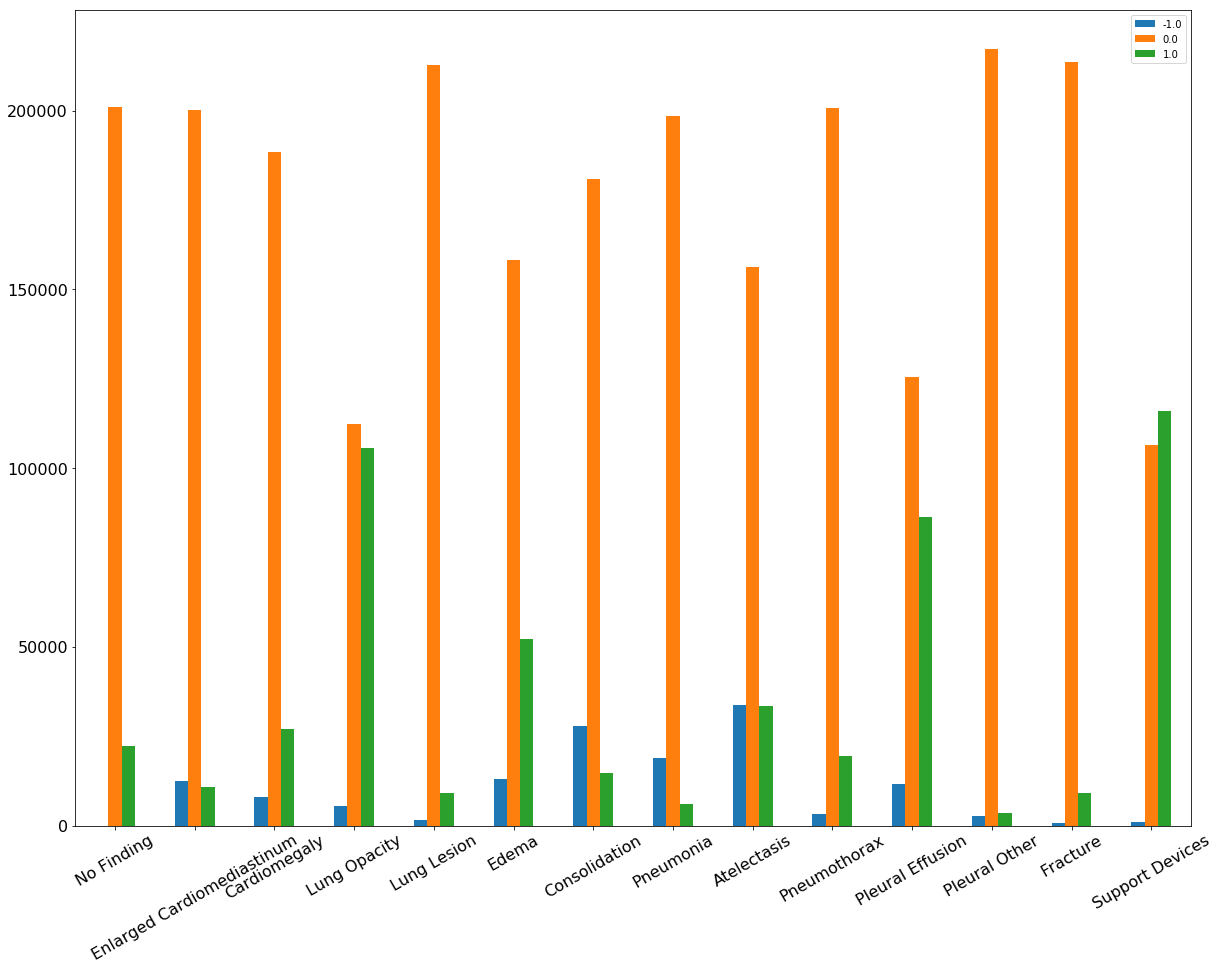

In [27]:
%matplotlib inline
t_c.plot.bar(rot=30,figsize=(20,15), fontsize=16)

### patient age distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f428b058710>]], dtype=object)

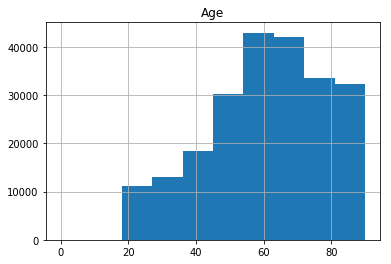

In [28]:
train.hist(column='Age')

# Test Set

In [8]:
# File location and type
file_location_train = "bd4h_valid.csv"

file_type = "csv"

# CSV options
infer_schema = "true" # this helps Spark to infer schema so as to be able to distinguish between numerical and string data.
# if this is set to false, all data is interpreted and stored as string.
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
valid_df = (spark.read.format(file_type) 
                    .option("inferSchema", infer_schema) 
                    .option("header", first_row_is_header) 
                    .option("sep", delimiter) 
                    .load(file_location_train))

print('Schema:')
valid_df.printSchema()


Schema:
root
 |-- Path: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Frontal/Lateral: string (nullable = true)
 |-- AP/PA: string (nullable = true)
 |-- No Finding: double (nullable = true)
 |-- Enlarged Cardiomediastinum: double (nullable = true)
 |-- Cardiomegaly: double (nullable = true)
 |-- Lung Opacity: double (nullable = true)
 |-- Lung Lesion: double (nullable = true)
 |-- Edema: double (nullable = true)
 |-- Consolidation: double (nullable = true)
 |-- Pneumonia: double (nullable = true)
 |-- Atelectasis: double (nullable = true)
 |-- Pneumothorax: double (nullable = true)
 |-- Pleural Effusion: double (nullable = true)
 |-- Pleural Other: double (nullable = true)
 |-- Fracture: double (nullable = true)
 |-- Support Devices: double (nullable = true)



In [9]:
validation  = valid_df.toPandas()
validation.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
print('# of Records',len(validation))
print()
print(validation['Frontal/Lateral'].value_counts())
print()
patient=list(map(lambda x: x.split('/')[2], validation.Path))
validation['Patient']=patient
print(validation['Patient'].value_counts()[:5])
print()

# of Records 234

Frontal    202
Lateral     32
Name: Frontal/Lateral, dtype: int64

patient64547    3
patient64581    3
patient64616    3
patient64640    2
patient64559    2
Name: Patient, dtype: int64



### Test label distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efc752205c0>]], dtype=object)

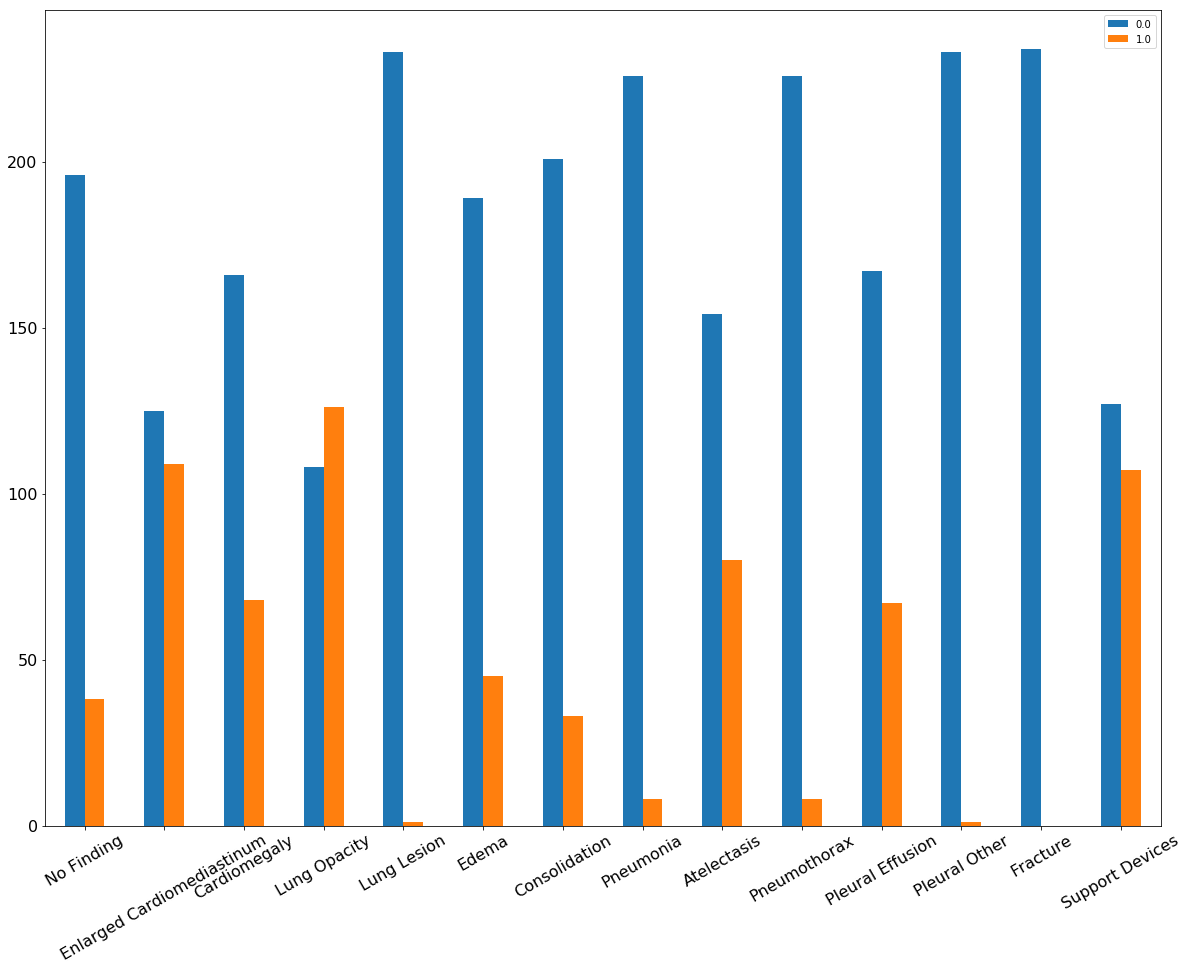

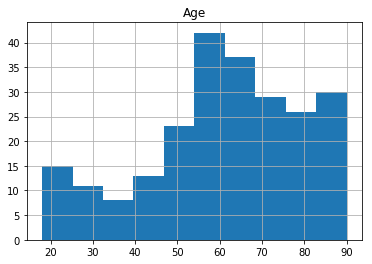

In [10]:

v_c=validation.iloc[:,5:19].apply(pd.value_counts)
v_c=v_c.T
v_c.plot.bar(rot=30,figsize=(20,15), fontsize=16)
validation.hist(column='Age')

In [19]:
validation.groupby('Frontal/Lateral').sum().T

Frontal/Lateral,Frontal,Lateral
Age,12285.0,1940.0
No Finding,26.0,12.0
Enlarged Cardiomediastinum,105.0,4.0
Cardiomegaly,66.0,2.0
Lung Opacity,117.0,9.0
Lung Lesion,1.0,0.0
Edema,42.0,3.0
Consolidation,32.0,1.0
Pneumonia,8.0,0.0
Atelectasis,75.0,5.0


In [20]:
Count = validation[validation.columns[5:]].apply(pd.Series.value_counts, dropna=False).T
Count

,0.0,1.0
No Finding,196.0,38.0
Enlarged Cardiomediastinum,125.0,109.0
Cardiomegaly,166.0,68.0
Lung Opacity,108.0,126.0
Lung Lesion,233.0,1.0
Edema,189.0,45.0
Consolidation,201.0,33.0
Pneumonia,226.0,8.0
Atelectasis,154.0,80.0
Pneumothorax,226.0,8.0
